# Import libraries

In [1]:
import os, sys
import subprocess
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import importlib.util
from chasm.coalescent_kpop_port import simulate_kpop_binary_genotypes
from chasm.parse_vars import parse_variables
from chasm.helpers import map_to_color
from chasm.make_inbred import simulate_inbred

# Parse variables

In [2]:
path_vars = f"../../geno_simulation.txt"
variables = parse_variables(path_vars)

if 'L' not in globals():
    L = int(variables['L'])
if 'c' not in globals():
    c = int(variables['c'])
if 'k' not in globals():
    k = int(variables['k'])
if 'M' not in globals():
    M = float(variables['M'])
if 'HWE' not in globals():
    HWE = int(variables['HWE'])
if 'F' not in globals():
    F = float(variables['F'])

if 'very_rare_threshold_L' not in globals():
    very_rare_threshold_L = float(variables['very_rare_threshold_L'])
if 'very_rare_threshold_H' not in globals():
    very_rare_threshold_H = float(variables['very_rare_threshold_H'])
if 'rare_threshold_L' not in globals():
    rare_threshold_L = float(variables['rare_threshold_L'])
if 'rare_threshold_H' not in globals():
    rare_threshold_H = float(variables['rare_threshold_H'])
if 'common_threshold_L' not in globals():
    common_threshold_L = float(variables['common_threshold_L'])
if 'common_threshold_H' not in globals():
    common_threshold_H = float(variables['common_threshold_H'])

# create Genotype

In [3]:
df = simulate_kpop_binary_genotypes(k=k, c=c, L=L, M=M, seed=123)

In [4]:
if HWE == 1:
    complete, maf_series = simulate_inbred(df, F=F, seed=123, do_random_flip=True)

else:
    df = df.copy()

In [5]:
complete

,V1_MAF_0.430,V2_MAF_0.430,V3_MAF_0.429,V4_MAF_0.429,V5_MAF_0.428,V6_MAF_0.428,V7_MAF_0.428,V8_MAF_0.427,V9_MAF_0.427,V10_MAF_0.427,...,V1992_MAF_0.050,V1993_MAF_0.050,V1994_MAF_0.049,V1995_MAF_0.049,V1996_MAF_0.048,V1997_MAF_0.047,V1998_MAF_0.047,V1999_MAF_0.047,V2000_MAF_0.046,populations
0,1,0,1,1,1,1,-1,1,1,-1,...,1,1,1,1,1,1,0,1,1,1
1,0,1,1,1,1,1,-1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
2,1,0,1,1,1,1,-1,1,1,-1,...,1,1,1,1,0,1,1,1,1,1
3,1,1,1,1,1,1,-1,1,0,-1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,0,-1,1,1,-1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-1,-1,-1,-1,-1,-1,1,-1,0,1,...,1,1,1,1,1,1,1,0,1,100
1996,-1,-1,-1,-1,-1,-1,1,-1,-1,1,...,1,1,1,1,1,1,1,1,0,100
1997,-1,-1,-1,-1,-1,-1,1,-1,-1,1,...,1,1,1,1,1,1,1,0,1,100
1998,0,-1,-1,-1,-1,-1,1,-1,-1,1,...,1,1,1,1,1,1,1,1,1,100


In [6]:
humans = complete[['populations']]
complete = complete.drop(columns = ['populations'])

# Create population labels

In [7]:
humans = humans.copy()
# Convert and calculate coordinates safely using .loc
humans.loc[:, 'populations'] = humans['populations'].astype(int)
humans.loc[:, 'x'] = ((humans['populations'] - 1) % k) + 1
humans.loc[:, 'y'] = ((humans['populations'] - 1) // k) + 1
humans.loc[:, 'z'] = F
humans.loc[:, 'population'] = humans['populations'] / (k * k)


In [8]:
# Sort columns by MAF
# Initialize lists to hold the DataFrames
very_rare_cols = []
rare_cols = []
common_cols = []

# Categorize columns based on allele frequency
for col in complete.columns:
    af_value = float(col.split('_')[2])
    if very_rare_threshold_L < af_value <= very_rare_threshold_H:
        very_rare_cols.append(complete[[col]].rename(columns={col: 'VR_' + col}))
    elif rare_threshold_L < af_value <= rare_threshold_H:
        rare_cols.append(complete[[col]].rename(columns={col: 'R_' + col}))
    elif common_threshold_L < af_value <= common_threshold_H:
        common_cols.append(complete[[col]].rename(columns={col: 'C_' + col}))

# Concatenate all collected DataFrames at once
very_rare = pd.concat(very_rare_cols, axis=1) if very_rare_cols else pd.DataFrame()
rare = pd.concat(rare_cols, axis=1) if rare_cols else pd.DataFrame()
common = pd.concat(common_cols, axis=1) if common_cols else pd.DataFrame()

# Concatenate the final DataFrame
complete = pd.concat([common, rare, very_rare], axis=1)

# Vizualize populations through PCA

In [9]:
try:
    scaler = StandardScaler()
    scaled_complete = scaler.fit_transform(complete)
    n_components = max(min(complete.shape[1], 50), 4)
    pca = PCA(n_components=n_components)
    pc_labels_complete = [f"PC{i}" for i in range(1, n_components + 1)]
    PC_complete = pca.fit_transform(scaled_complete)
    PC_complete = pd.DataFrame(data=PC_complete, columns=pc_labels_complete)

except:
    print("nothing in complete")
    PC_complete = pd.DataFrame(np.zeros((len(complete), 4)), columns=['PC1', 'PC2', 'PC3', 'PC4'])
    
try:
    scaler = StandardScaler()
    scaled_common = scaler.fit_transform(common)
    n_components = max(min(common.shape[1], 50), 4)
    pca = PCA(n_components=n_components)
    pc_labels_common = [f"PC{i}" for i in range(1, n_components + 1)]
    PC_common = pca.fit_transform(scaled_common)
    PC_common = pd.DataFrame(data=PC_common, columns=pc_labels_common)
except:
    print("common is empty")
    PC_common = pd.DataFrame(np.zeros((len(common), 4)), columns=['PC1', 'PC2', 'PC3', 'PC4'])
    
try:
    scaler = StandardScaler()
    scaled_rare = scaler.fit_transform(rare)
    n_components = max(min(rare.shape[1], 50), 4)
    pca = PCA(n_components=n_components)
    pc_labels_rare = [f"PC{i}" for i in range(1, n_components + 1)]
    PC_rare = pca.fit_transform(scaled_rare)
    PC_rare = pd.DataFrame(data=PC_rare, columns=pc_labels_rare)
except:
    print("rare is empty")
    PC_rare = pd.DataFrame(np.zeros((len(rare), 4)), columns=['PC1', 'PC2', 'PC3', 'PC4'])
    
try:
    scaler = StandardScaler()
    scaled_veryrare = scaler.fit_transform(very_rare)
    n_components = max(min(very_rare.shape[1], 50), 4)
    pca = PCA(n_components=n_components)
    pc_labels_very_rare = [f"PC{i}" for i in range(1, n_components + 1)]
    PC_veryrare = pca.fit_transform(scaled_veryrare)
    PC_veryrare = pd.DataFrame(data=PC_veryrare, columns=pc_labels_very_rare)
except:
    print("very rare is empty")
    PC_veryrare = pd.DataFrame(np.zeros((len(very_rare), 4)), columns=['PC1', 'PC2', 'PC3', 'PC4'])

In [10]:
to_have_collumns = ['populations', 'x', 'y', 'population']
PC_complete[to_have_collumns] = humans[to_have_collumns]
PC_common[to_have_collumns] = humans[to_have_collumns]
PC_rare[to_have_collumns] = humans[to_have_collumns]
PC_veryrare[to_have_collumns] = humans[to_have_collumns]

In [11]:
number_of_snps = complete.shape[1]
number_of_individuals = complete.shape[0]

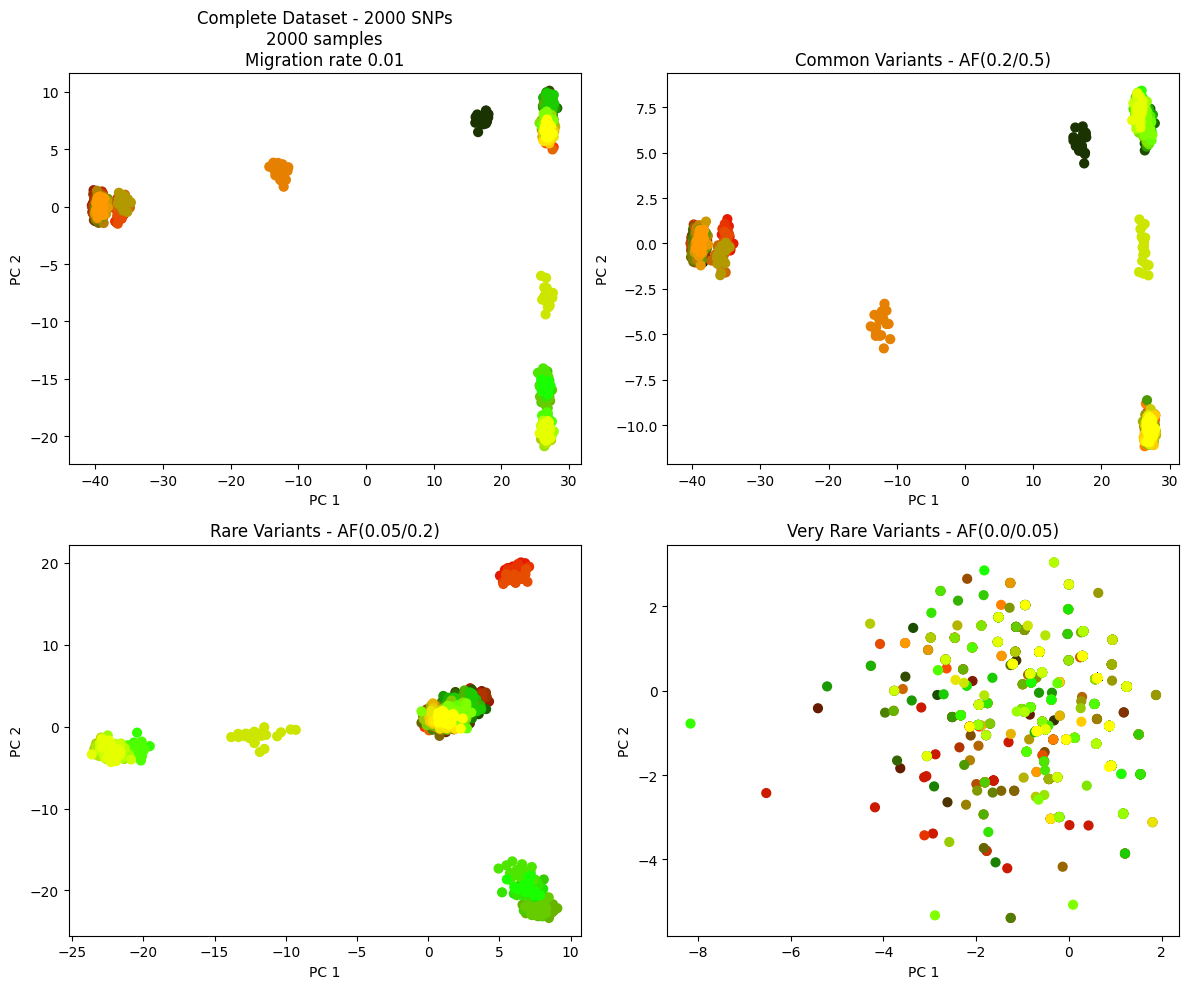

In [12]:
# Generate color mapping for the 'humans' DataFrame
colors = [map_to_color(x, y, z, humans) for x, y, z in zip(humans['x'], humans['y'], humans['z'])]
# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

dataframes = [PC_complete, PC_common, PC_rare, PC_veryrare]
titles = [f"Complete Dataset - {number_of_snps} SNPs\n{number_of_individuals} samples\nMigration rate {M}",
          f"Common Variants - AF({common_threshold_L}/{common_threshold_H})", 
          f"Rare Variants - AF({rare_threshold_L}/{rare_threshold_H})", 
          f"Very Rare Variants - AF({very_rare_threshold_L}/{very_rare_threshold_H})"]

# Iterate through dataframes, axes, and titles
for df, ax, title in zip(dataframes, axes.flatten(), titles):
    # Count the unique values in the 'populations' column
    unique_populations = df['populations'].nunique()
    # Plotting the principal components with colors
    ax.scatter(x=df['PC1'], y=df['PC2'], c=colors, s=40)
    
    ax.set_title(title)  # Set the title for the current subplot
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.legend([],[], frameon=False) # This hides the legend

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()
plt.close()

# Save data

In [22]:
path_geno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/genotype"
path_pheno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/phenotype/"
os.makedirs(path_geno, exist_ok = True)
os.makedirs(path_pheno,exist_ok=True)

In [23]:
complete.to_pickle(f"{path_geno}/complete_inbred.pkl")
humans[['populations', 'x','y']].to_pickle(f"{path_pheno}/inbred_humans.pkl")